In [1]:
import pandas as pd
import numpy as np
import ipaddress
import seaborn as sns

from scapy.all import PcapReader, IP, TCP, UDP, ICMP, rdpcap
from scipy.stats import ttest_ind, kstest, norm, skew, kurtosis, zscore
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [2]:
# first time you run this, you should create your own pkl
# for security reasons we do not recommend to use untrusted pkl files
READ_FROM_PKL = False

# Preprocess

- convert data to streams
- collect some numbers

In [3]:
def pcap_to_dataframe(pcap_reader: PcapReader) -> pd.DataFrame:
    """Converts raw packet capture to a Pandas dataframe.

    Args:
        pcap_reader (PcapReader): packet capture read using scapy

    Returns:
        pd.DataFrame: dataframe with pcap data
    """
    # Create an empty list to store the data
    data = []

    # Iterate through the packets in the pcap file
    for packet in pcap_reader:
        # Get the source and destination IP addresses
        if packet.haslayer(IP):
            src_ip = packet[IP].src
            dst_ip = packet[IP].dst
            protocol = packet[IP].proto
        else:
            src_ip = None
            dst_ip = None
            protocol = None

        # Get the source and destination ports and payload
        if packet.haslayer(TCP):
            src_port = packet[TCP].sport
            dst_port = packet[TCP].dport
            payload = str(packet[TCP].payload)
            packet_len = len(packet[TCP])
        elif packet.haslayer(UDP):
            src_port = packet[UDP].sport
            dst_port = packet[UDP].dport
            payload = str(packet[UDP].payload)
            packet_len = len(packet[UDP])
        elif packet.haslayer(ICMP):
            payload = str(packet[ICMP].payload)
            packet_len = len(packet[ICMP])
            src_port = None
            dst_port = None
        else:
            src_port = None
            dst_port = None
            payload = str(packet.payload)
            packet_len = len(packet)

        # Append the data to the list
        data.append(
            [
                packet.time,
                src_ip,
                dst_ip,
                src_port,
                dst_port,
                payload,
                packet_len,
                protocol,
            ]
        )

    # Convert the list to a pandas dataframe
    df = pd.DataFrame(
        data,
        columns=[
            "Timestamp",
            "Source IP",
            "Destination IP",
            "Source Port",
            "Destination Port",
            "Payload",
            "Packet Length",
            "Protocol",
        ],
    )

    return df

In [4]:
if READ_FROM_PKL:
    mirai_df = pd.read_pickle("../data/blog_eda/mirai.pkl")
    benign_df = pd.read_pickle("../data/blog_eda/benign.pkl")
else:
    mirai_pcap = rdpcap("../data/blog_eda/mirai.pcap")
    benign_pcap = rdpcap("../data/blog_eda/benign.pcapng")
    mirai_df = pcap_to_dataframe(mirai_pcap)
    benign_df = pcap_to_dataframe(benign_pcap)
    # save to pkl since dataframe conversion takes a long time
    mirai_df.to_pickle("../data/blog_eda/mirai.pkl")
    benign_df.to_pickle("../data/blog_eda/benign.pkl")

In [36]:
type(mirai_pcap)

scapy.plist.PacketList

In [5]:
mirai_df

,Timestamp,Source IP,Destination IP,Source Port,Destination Port,Payload,Packet Length,Protocol
0,1540446382.933899,192.168.2.108,52.24.43.67,21074.0,80.0,Padding,26,6.0
1,1540446382.933904,192.168.2.108,52.25.66.250,20532.0,8280.0,Padding,26,6.0
2,1540446382.934426,192.168.2.1,192.168.2.108,NaN,NaN,IPerror / TCPerror,52,1.0
3,1540446382.934636,192.168.2.1,192.168.2.108,NaN,NaN,IPerror / TCPerror,52,1.0
4,1540446383.291054,None,None,NaN,NaN,ARP who has 192.168.2.106 says 192.168.2.109 /...,60,NaN
...,...,...,...,...,...,...,...,...
764132,1540453519.837515,None,None,NaN,NaN,ARP who has 192.168.2.165 says 192.168.2.110 /...,60,NaN
764133,1540453519.839396,None,None,NaN,NaN,ARP who has 192.168.2.166 says 192.168.2.110 /...,60,NaN
764134,1540453519.840611,None,None,NaN,NaN,ARP who has 192.168.2.167 says 192.168.2.110 /...,60,NaN
764135,1540453519.842369,None,None,NaN,NaN,ARP who has 192.168.2.168 says 192.168.2.110 /...,60,NaN


In [6]:
benign_df

,Timestamp,Source IP,Destination IP,Source Port,Destination Port,Payload,Packet Length,Protocol
0,1241422456.122475,None,None,NaN,NaN,Raw,60,NaN
1,1241422456.122475,None,None,NaN,NaN,Raw,60,NaN
2,1241422758.60905,None,None,NaN,NaN,Raw,60,NaN
3,1241422758.60905,None,None,NaN,NaN,Raw,60,NaN
4,1355253962.658551,10.0.0.1,224.0.0.2,646.0,646.0,Raw,42,17.0
...,...,...,...,...,...,...,...,...
38637,1671112304.885062,None,None,1812.0,43398.0,Radius,502,NaN
38638,1671112304.921208,None,None,43398.0,1812.0,Radius,225,NaN
38639,1671112304.926982,None,None,1812.0,43398.0,Radius,127,NaN
38640,1671112304.950305,None,None,43398.0,1812.0,Radius,180,NaN


In [7]:
def extract_flows(df: pd.DataFrame) -> pd.DataFrame:
    # Create an empty list to store stream data as separate dataframes
    dfs = []

    # Group packets by src/dst IP and src/dst port
    grouped = df.groupby(
        ["Source IP", "Destination IP", "Source Port", "Destination Port", "Protocol"]
    )

    # Iterate through each group to extract stream data
    for name, group in grouped:
        # Get source/destination IP, port, and protocol
        src_ip, dst_ip, src_port, dst_port, proto = name

        # Get number of packets, total length, and duration of the stream
        num_packets = len(group)
        total_length = group["Packet Length"].sum()
        start_time = group["Timestamp"].min()
        end_time = group["Timestamp"].max()
        duration = float(end_time - start_time)

        # Create a new dataframe with the stream data
        flow_df = pd.DataFrame(
            {
                "Source IP": [src_ip],
                "Destination IP": [dst_ip],
                "Source Port": [src_port],
                "Destination Port": [dst_port],
                "Protocol": [proto],
                "Number of Packets": [num_packets],
                "Total Length": [total_length],
                "Duration": [duration],
            }
        )

        # Add the new dataframe to the list
        dfs.append(flow_df)

    # Concatenate all the dataframes in the list into one dataframe
    flow_df = pd.concat(dfs, ignore_index=True)

    # Return the new dataframe with stream data
    return flow_df

In [8]:
mirai_flow_df = extract_flows(mirai_df)
benign_flow_df = extract_flows(benign_df)

# EDA

Exploratory Data Analysis approaches the dataset as a black box that we need to visualize and analyze statistically with the following goals:
- get insights about our data
- test hypotheses
- decide on models and further processing, such as feature engineering.

EDA can be performed for benign and malicious data. Here we are looking at EDA only for malicious data, however the same functions can be applied to benign.

## Descriptive statistics & data

- Describe columns and data types
- Descriptive statistics
  -  count, 
  -  mean, 
  -  standard deviation, 
  -  minimum, 
  -  25th percentile, 
  -  median (50th percentile), 
  -  75th percentile, and 
  -  maximum

In [9]:
# describe, summarize etc.
mirai_flow_df.columns

Index(['Source IP', 'Destination IP', 'Source Port', 'Destination Port',
       'Protocol', 'Number of Packets', 'Total Length', 'Duration'],
      dtype='object')

In [10]:
mirai_flow_df.dtypes

Source IP             object
Destination IP        object
Source Port          float64
Destination Port     float64
Protocol             float64
Number of Packets      int64
Total Length           int64
Duration             float64
dtype: object

In [11]:
# descriptive statistics
mirai_flow_df.describe()

,Source Port,Destination Port,Protocol,Number of Packets,Total Length,Duration
count,36585.000000,36585.000000,36585.000000,36585.000000,36585.000000,36585.000000
mean,35013.168484,2179.724915,12.997185,4.211835,190.795681,327.060315
std,20907.744322,6022.524810,5.292372,104.750186,4959.106974,1284.088269
min,0.000000,23.000000,6.000000,1.000000,26.000000,0.000000
25%,12435.000000,53.000000,6.000000,1.000000,40.000000,0.000000
50%,41283.000000,53.000000,17.000000,1.000000,49.000000,0.000000
75%,51545.000000,443.000000,17.000000,3.000000,104.000000,2.992908
max,65267.000000,65267.000000,17.000000,7853.000000,376944.000000,7135.502403


In [12]:
# correlation matrix for numerical values in dataframe
mirai_flow_df.corr()

/tmp/ipykernel_3584069/3893345276.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mirai_flow_df.corr()


,Source Port,Destination Port,Protocol,Number of Packets,Total Length,Duration
Source Port,1.000000,-0.137491,-0.280543,-0.006830,-0.008757,-0.352542
Destination Port,-0.137491,1.000000,-0.213777,0.030570,0.028732,-0.030991
Protocol,-0.280543,-0.213777,1.000000,0.002669,0.010510,0.183307
Number of Packets,-0.006830,0.030570,0.002669,1.000000,0.988055,0.099866
Total Length,-0.008757,0.028732,0.010510,0.988055,1.000000,0.105296
Duration,-0.352542,-0.030991,0.183307,0.099866,0.105296,1.000000


## Hypothesis testing

- Is the difference between two groups or variables statistically significant?
- Use t-test to compare means of two groups
  - assumes that data follows normal distribution
- Types of variables
  - dependent: the effect of a phenomenon. For example, how does number of HTTP requests mean that a network is compromised?
  - independent: the cause. The number of HTTP requests affects whether a network is compromised.

In [13]:
def hypothesis_testing(df1, df2, col):
    group1 = df1[col]
    group2 = df2[col]
    pvalue = ttest_ind(group1, group2)[1]
    if pvalue < 0.05:
        return "The difference between benign and mirai traffic {} is statistically significant (p < 0.05)".format(
            col
        )
    else:
        return "The difference between benign and mirai traffic {} is not statistically significant (p >= 0.05)".format(
            col
        )

In [14]:
hypothesis_testing(mirai_flow_df, benign_flow_df, "Number of Packets")

'The difference between benign and mirai traffic Number of Packets is statistically significant (p < 0.05)'

## Outliers

- observation that significantly differs from others in a dataset
- Causes
  - measurement errors
  - extreme rare values
- significant impact in statistical analysis
- measurements
  - z-score: `(x - mean) / std_dev`
  - IQR method: this method identifies outliers as observations that are below `Q1 - 1.5IQR` or above `Q3 + 1.5IQR`, where Q1 and Q3 are the first and third quartiles, and IQR is the interquartile range (the difference between Q3 and Q1).
  - visual inspection

In [15]:
def detect_outliers_zscore(df, column, threshold=3):
    zscores = np.abs(zscore(df[column]))
    return df[zscores > threshold]

In [16]:
outliers = detect_outliers_zscore(mirai_flow_df, "Total Length", threshold=3)
print(outliers)

           Source IP   Destination IP  Source Port  Destination Port  \
1        192.168.2.1    192.168.2.110         23.0           21897.0   
3651     192.168.2.1  239.255.255.250       1900.0            1900.0   
3652     192.168.2.1  255.255.255.255         67.0              68.0   
3653   192.168.2.101    192.168.2.110         23.0           21897.0   
3673   192.168.2.103    192.168.2.110         23.0           21897.0   
4928   192.168.2.107    192.168.2.110         23.0           21897.0   
4933   192.168.2.108   122.226.84.253      32761.0           10240.0   
4934   192.168.2.108  122.248.234.207      32761.0           10240.0   
4935   192.168.2.108    46.137.188.54      32761.0           10240.0   
4936   192.168.2.108    50.19.254.134      32761.0           10240.0   
8014   192.168.2.108    61.188.37.216      32761.0           10240.0   
16232  192.168.2.110      192.168.2.1      21897.0              23.0   
18022  192.168.2.110    192.168.2.101      21897.0              

# Feature Engineering

## Numerical

In [17]:
# convert ip address to numeric values
def ip_to_numeric(ip):
    ip_obj = ipaddress.ip_interface(ip)
    return int(ip_obj.network.network_address)

In [18]:
# convert IPs to numeric mirai data
mirai_flow_df["Source IP Numeric"] = mirai_flow_df["Source IP"].apply(ip_to_numeric)
mirai_flow_df["Destination IP Numeric"] = mirai_flow_df["Destination IP"].apply(
    ip_to_numeric
)

In [19]:
# convert IPs to numeric benign data
benign_flow_df["Source IP Numeric"] = benign_flow_df["Source IP"].apply(ip_to_numeric)
benign_flow_df["Destination IP Numeric"] = benign_flow_df["Destination IP"].apply(
    ip_to_numeric
)

In [20]:
# get rid of non numeric columns for IPs
mirai_flow_df_numeric = mirai_flow_df.drop(columns=["Source IP", "Destination IP"])
benign_flow_df_numeric = benign_flow_df.drop(columns=["Source IP", "Destination IP"])

In [21]:
# convert duration from object to float
mirai_flow_df["Duration"] = mirai_flow_df_numeric["Duration"].astype(float)
benign_flow_df["Duration"] = benign_flow_df_numeric["Duration"].astype(float)

In [22]:
# check if all data types are numeric now
mirai_flow_df_numeric.dtypes

Source Port               float64
Destination Port          float64
Protocol                  float64
Number of Packets           int64
Total Length                int64
Duration                  float64
Source IP Numeric           int64
Destination IP Numeric      int64
dtype: object

In [23]:
# save dataframes to pickles, can be used in the next blog
if READ_FROM_PKL:
    mirai_flow_df_numeric.to_pickle("../data/blog_eda/mirai_flow_numeric.pkl")
    benign_flow_df_numeric.to_pickle("../data/blog_eda/benign_flow_numeric.pkl")
else:
    mirai_flow_df_numeric = pd.read_pickle("../data/blog_eda/mirai_flow_numeric.pkl")
    benign_flow_df_numeric = pd.read_pickle("../data/blog_eda/mirai_flow_numeric.pkl")

# More EDA
After converting all columns to numerical, we can do more exploration.

## Correlation

In [24]:
# Calculate the correlation matrix
correlation_matrix = mirai_flow_df_numeric.corr()

# Print the correlation matrix and autocorrelation
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                        Source Port  Destination Port  Protocol  \
Source Port                1.000000         -0.137491 -0.280543   
Destination Port          -0.137491          1.000000 -0.213777   
Protocol                  -0.280543         -0.213777  1.000000   
Number of Packets         -0.006830          0.030570  0.002669   
Total Length              -0.008757          0.028732  0.010510   
Duration                  -0.352542         -0.030991  0.183307   
Source IP Numeric          0.008740          0.001834 -0.003955   
Destination IP Numeric    -0.390018         -0.106866  0.506925   

                        Number of Packets  Total Length  Duration  \
Source Port                     -0.006830     -0.008757 -0.352542   
Destination Port                 0.030570      0.028732 -0.030991   
Protocol                         0.002669      0.010510  0.183307   
Number of Packets                1.000000      0.988055  0.099866   
Total Length                   

In [25]:
# Calculate the correlation matrix
correlation_matrix = benign_flow_df_numeric.corr()

# Print the correlation matrix and autocorrelation
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                        Source Port  Destination Port  Protocol  \
Source Port                1.000000         -0.137491 -0.280543   
Destination Port          -0.137491          1.000000 -0.213777   
Protocol                  -0.280543         -0.213777  1.000000   
Number of Packets         -0.006830          0.030570  0.002669   
Total Length              -0.008757          0.028732  0.010510   
Duration                  -0.352542         -0.030991  0.183307   
Source IP Numeric          0.008740          0.001834 -0.003955   
Destination IP Numeric    -0.390018         -0.106866  0.506925   

                        Number of Packets  Total Length  Duration  \
Source Port                     -0.006830     -0.008757 -0.352542   
Destination Port                 0.030570      0.028732 -0.030991   
Protocol                         0.002669      0.010510  0.183307   
Number of Packets                1.000000      0.988055  0.099866   
Total Length                   

In [26]:
# get random subset of dataframe
mirai_flow_df_numeric_sample = mirai_flow_df_numeric.sample(100)
mirai_flow_df_numeric_sample

,Source Port,Destination Port,Protocol,Number of Packets,Total Length,Duration,Source IP Numeric,Destination IP Numeric
21886,42574.0,53.0,17.0,1,42,0.000000,3232236144,3232236033
5819,28443.0,80.0,6.0,4,104,1.524167,3232236140,873999171
28890,58534.0,80.0,6.0,2,80,0.993210,3232236145,711196322
22893,48328.0,80.0,6.0,2,80,0.988407,3232236144,780778550
24253,36214.0,21047.0,6.0,1,40,0.000000,3232236144,840171142
...,...,...,...,...,...,...,...,...
839,53.0,1749.0,17.0,2,161,1.561358,3232236033,3232236147
2934,53.0,4198.0,17.0,1,83,0.000000,3232236033,3232236147
23440,50790.0,80.0,6.0,1,40,0.000000,3232236144,780778550
11095,46020.0,53.0,17.0,1,37,0.000000,3232236141,3232236033


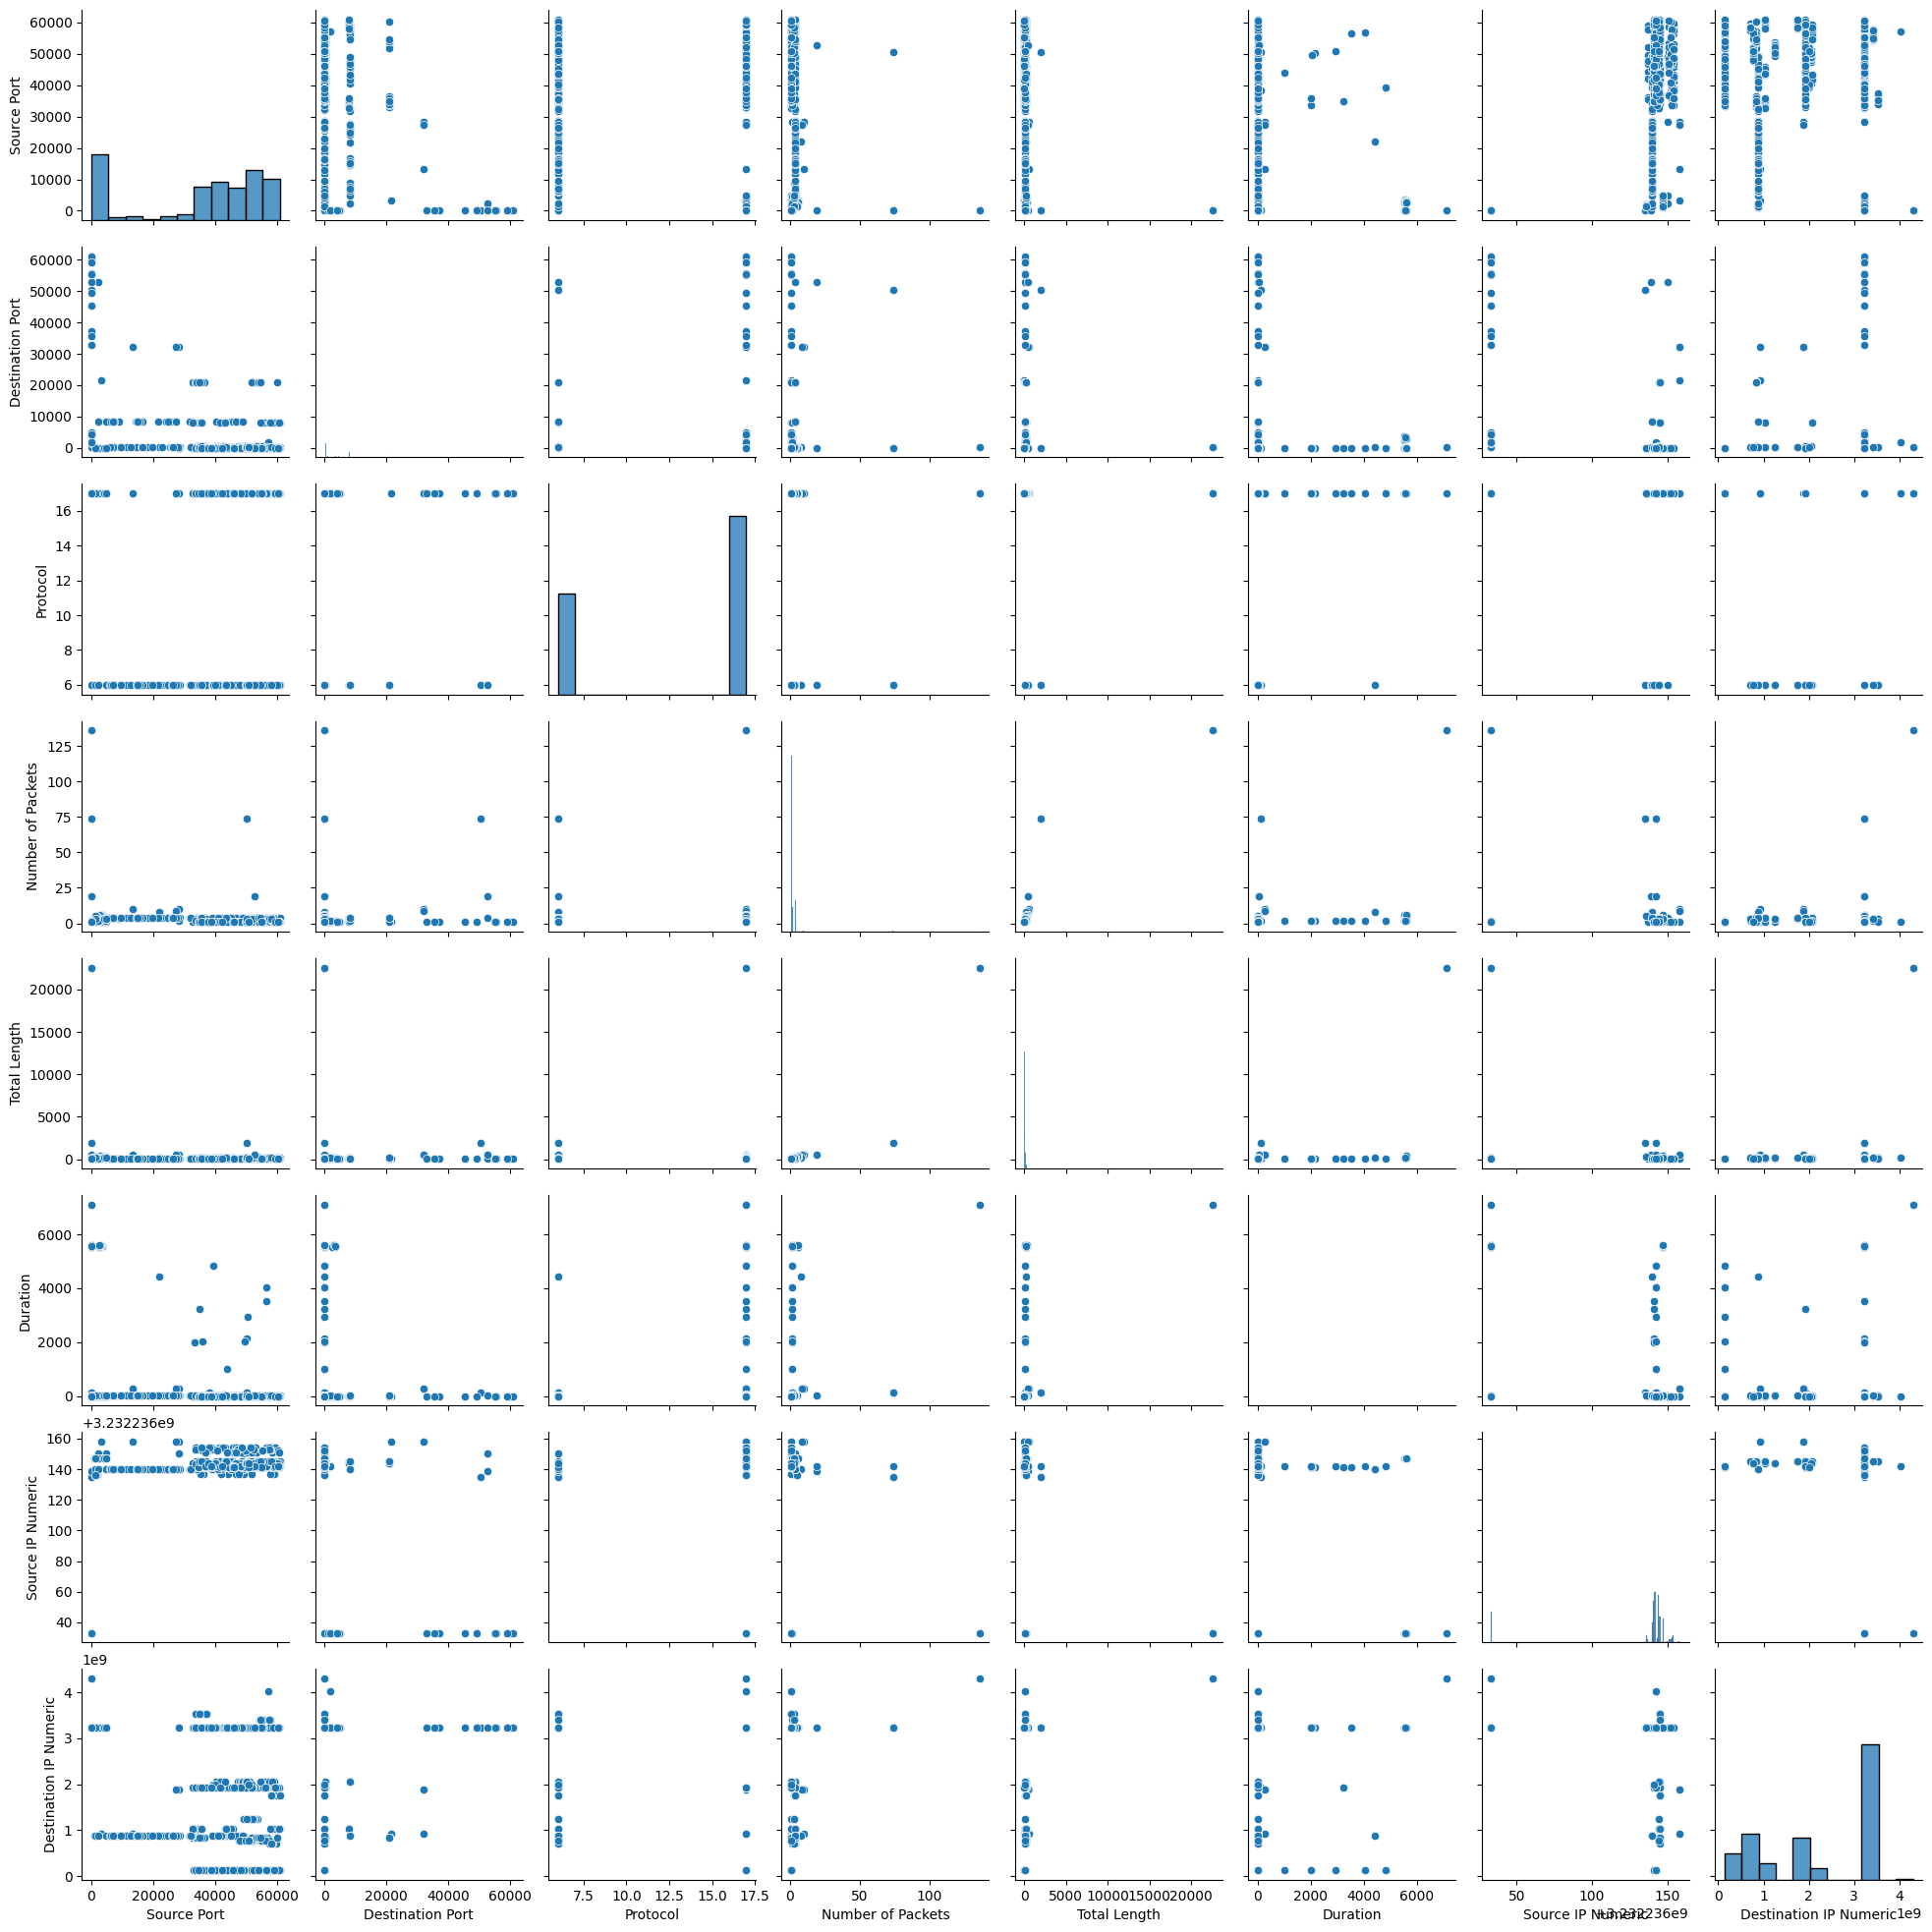

In [27]:
# Create the default pairplot
# this is an alternative way to look at correlation
# very useful when there are outliers in data and correlation may be misleading
sns.pairplot(mirai_flow_df_numeric_sample)

In [28]:
# get random subset of dataframe
benign_flow_df_numeric_sample = benign_flow_df_numeric.sample(100)

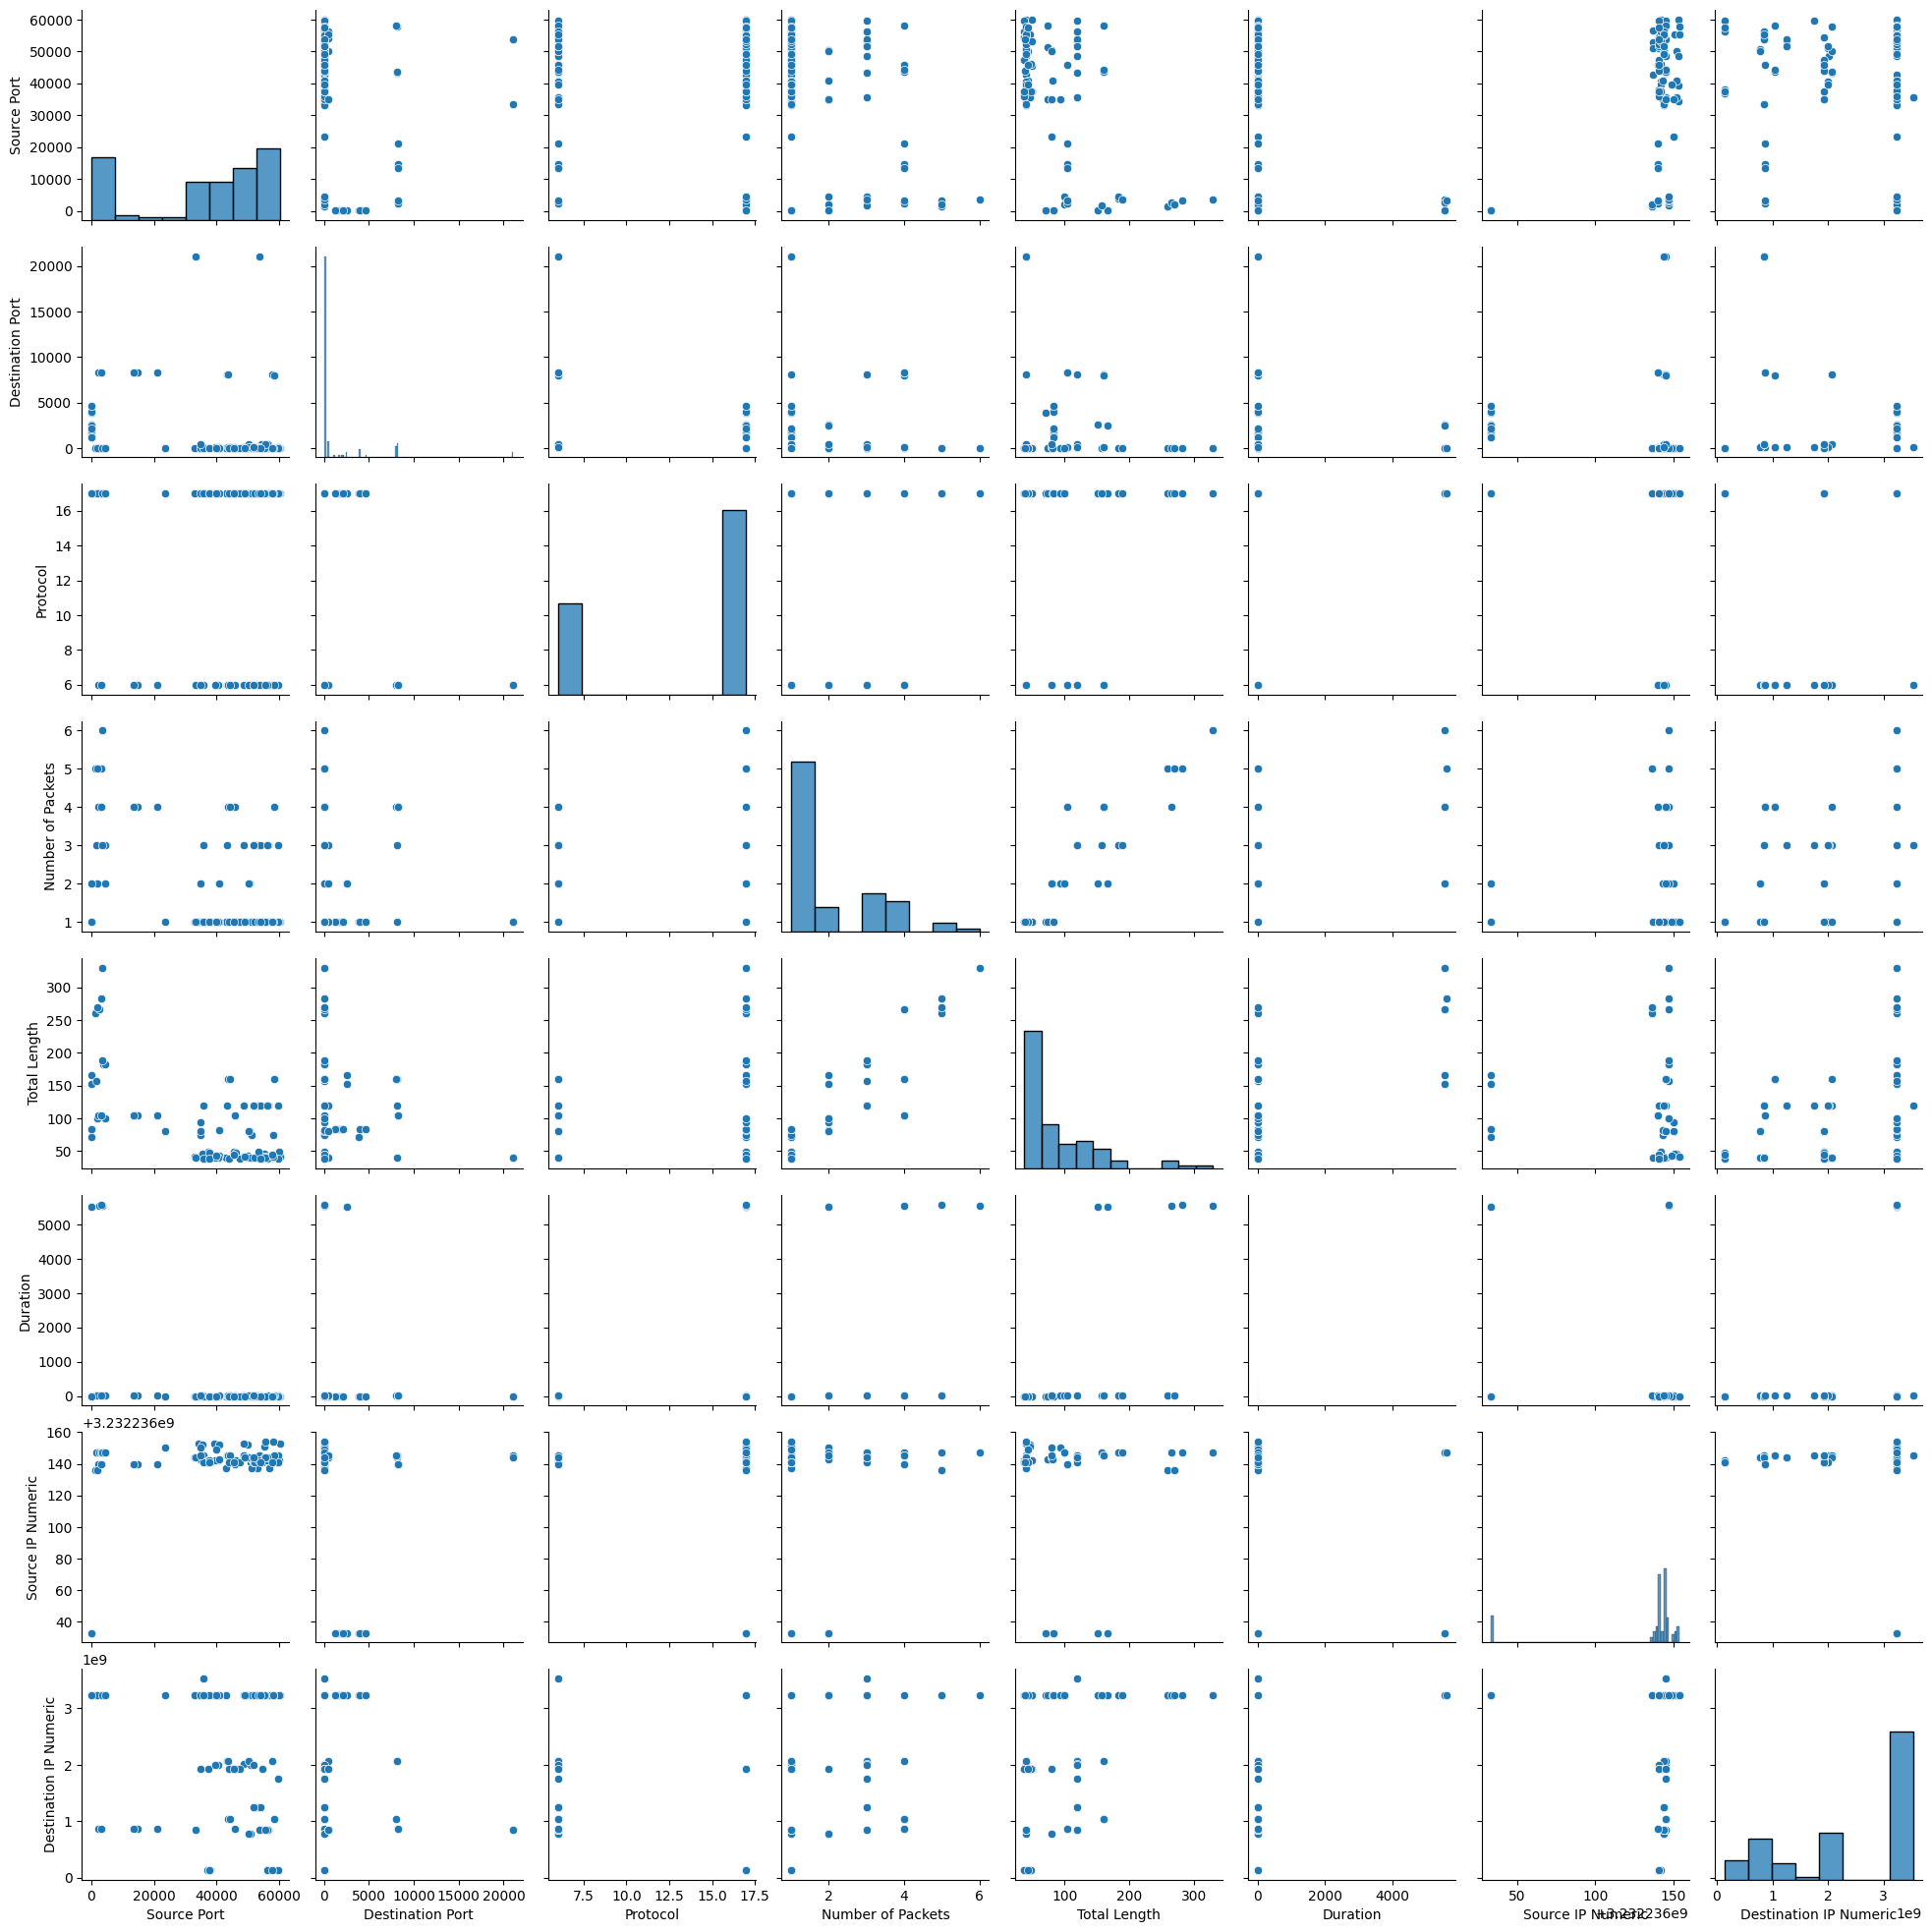

In [29]:
sns.pairplot(benign_flow_df_numeric_sample)

## Autocorrelation

In [30]:
# Calculate the autocorrelation for a specific column (e.g., 'Number of Packets')
autocorrelation = mirai_flow_df_numeric["Number of Packets"].autocorr()

print("\nAutocorrelation for 'Number of Packets':")
print(autocorrelation)


Autocorrelation for 'Number of Packets':
0.47011877619061265


In [31]:
# Calculate the autocorrelation for a specific column (e.g., 'Number of Packets')
autocorrelation = benign_flow_df_numeric["Number of Packets"].autocorr()

print("\nAutocorrelation for 'Number of Packets':")
print(autocorrelation)


Autocorrelation for 'Number of Packets':
0.47011877619061265
